# Patch Generator
### On this notebook, we will generate the patches to be used for training.

### We can choose the patch zise, the stride to generate patches, which type of images will be used for validation, the minimum amount of positive pixels for a patch to be considered as positive, and some other features of the patches to be generated (see full explanation further below).

### Data was already downloaded into the Git Repository, in the folder '../Data', which contains the following subfolders:
    1. Serial: Folder containing all 'Serial' type images.
    2. Control: Folder containing all 'Control' type images.
    3. Streak: Folder containing all 'Streak' type images.

### In addition, <span style="color:blue">*prepocessed images*</span>  can already be found in <span style="color:blue">'../Data/no_dish_border/'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all pre-processed 'Serial' type images.
    2. Control: Folder containing all pre-processed 'Control' type images.
    3. Streak: Folder containing all pre-processed 'Streak' type images.
    
### Positive pixel <span style="color:blue">*Masks*</span> were already obtained and can be found in <span style="color:blue">'../Data/Masks'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all positive masks for 'Serial' type images.
    2. Control: Folder containing all positive masks for 'Control' type images.
    3. Streak: Folder containing all positive masks for 'Streak' type images.
    
### Using the positive pixel masks, <span style="color:blue">*positive-pixels-only images*</span> were generated and can be found in <span style="color:blue">'../Data/pos_pixel_only/'</span> folder also containing the following subfolders:
    1. Serial: Folder containing all positive-pixels-only images for 'Serial' type images.
    2. Control: Folder containing all positive-pixels-only images for 'Control' type images.
    3. Streak: Folder containing all positive-pixels-only images for 'Streak' type images.

### Let's import necessary libraries / modules:

In [139]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from PIL import Image, ImageOps
import cv2 as cv

%matplotlib inline
%reload_ext autoreload
%autoreload 2

### Helper Function: get a list of 'complete' file paths of all images in a given folder:

In [140]:
def get_files(folder):
    """
    Returns a list of file_paths for each file in the specified folder. 
    :param folder: The folder where files are located.
    :return: A list of file_paths for each file in the specified folder.
    """
    files = os.listdir(folder)
    paths = []
    for x in files:
        paths.append(os.path.join(folder, x))
    return paths

### Helper Function: 
#### Create all needed folders and subfolders.

In [141]:
def create_folders(patch_size, types, patch_types):
    """
    Create all needed folders to save the created Patches.
    :param patch_size: Tuple. (Patch_width, Patch_height) e.g. (64 ,64).
    :return: save_dir. The root directory where Patches will be saved.
    """ 
    folder_name = 'Patches_' + str(patch_size[0]) + 'x' + str(patch_size[1])
    save_dir = '../Data/' + folder_name + '/'
    
    if folder_name in os.listdir('../Data'):
        shutil.rmtree(save_dir)
    os.mkdir(save_dir)
    
    for folder in ['Positive', 'Negative']:
        path = save_dir + '/' + folder
        os.mkdir(path)
        for type in ['Serial', 'Control', 'Streak']:
            type_path = path + '/' + type
            os.mkdir(type_path)
            for i in range(1,11):
                loc = 'C{}_{}'.format(i, folder.lower()[:3])
                loc_path = type_path + '/' + loc
                os.mkdir(loc_path)           
    return save_dir

## Patch Generator function

In [142]:
def create_patches(img_types, patch_types, patch_size, stride, min_pos_pixels, validation_type,
                   val_stride, val_min_pos_pixels, include_dish_border=False,
                   positive_pixels_only=False, rotate_every=False, rotate_val_every=False):
    """
    Creates patches for training.
    :param img_types: List. List of images types patching. Any combination from ['Serial',
                         'Control', 'Stride'] -one, two or all three-.
    :param patch_types: List. List with types of patches to generate for each location.
                        Either ['Positive'] or ['Negative'] or ['Positive','Negative'].
    :param patch_size: Tuple. (patch_width, patch_height) e.g. (64 ,64).
    :param stride: Tuple. (horizontal_stride, vertical_stride).
                   Amount of pixels to move right or down  to generate next patch.
    :param min_pos_pixels: Integer. Minimum positive pixels in patches.
                           Values from 1 pixel to patch_width*patch_height (all pixels).
    :param validation_type: Str. Type of images to be used for model validation.
                                 either 'Control', 'Serial', 'Strike' or None.
    :param val_stride: Tuple. (horizontal_stride, vertical_stride) for validation patches.
                   Amount of pixels to move right or down  to generate next validation patch.
    :param include_dish_border: Boolean. True ->  include petri-dish border in training patches.
    :param positive_pixels_only: Boolean. True -> patches with positive pixels only.
                                 False -> natural images including dish background (default).
    :param rotate_every: Int [0-360] or False. Amount of degrees to rotate the image around the
                        image center, for data augmentation. The image will be rotated as many
                        times as needed to complte a full rotation. If rotate_every = 0 or 360
                        or False, then no rotation will be performed.
    :param rotate_val_every: Int [0-360] or False. Same concept than 'rotate_every' (see above)
                             but in this case it will be the degrees to rotate the 'Validation'
                             images around the image center.                        
    :return: save_dir. The root directory where Patches were saved.
    """ 
    if positive_pixels_only and include_dish_border:
        print("No border will be included when 'positive_pixels_only=TRUE'")
    if positive_pixels_only and 'Negative' in patch_types:
        print("No negative patches will be generated when 'positive_pixels_only=TRUE'")
        
    save_dir = create_folders(patch_size, img_types, patch_types)
    width, height = patch_size
    max_pixels = width * height * 255 # maximum pixel sum if all pixels in patch were white (255)
    root = '../Data/no_dish_border/'
    if include_dish_border: root = '../Data/'
    if positive_pixels_only: root = '../Data/pos_pixel_only/'
    
    for type in img_types:
        print('\ngenerating "{}" patches...............'.format(type)) 
        img_folder = root + type
        if type == validation_type: img_folder = '../Data/' + type
        images = get_files(img_folder) # Returns array of all file_paths in the specified folder.
        move, min_pos = stride, min_pos_pixels
        if type == validation_type: move, min_pos = val_stride,val_min_pos_pixels
        
        if rotate_every and rotate_every != 0 and type != validation_type:
            n_rotations = round(360/rotate_every)
        elif rotate_val_every and rotate_val_every != 0 and type==validation_type:
            n_rotations = round(360/rotate_val_every)
        else:
            n_rotations = 1
        
        for img_path in images:
            if 'no_blue_numbers' in img_path: continue
            original_img = Image.open(img_path)
            imgwidth, imgheight = original_img.size 
            for i in range(1,11):
                if 'C{}_'.format(i) in img_path:
                    loc = '/C{}_'.format(i)
            mask_path = '../Data/Masks/' + type + img_path[len(img_folder):]
            original_mask = Image.open(mask_path)    
            
            """We need to discard contaminated negative patches:"""
            original_neg_mask, neg_mask = False, False                
            if 'C9_' in img_path or 'C2_' in img_path or 'C10_' in img_path:
                if type == 'Serial' and 'Negative' in patch_types and not positive_pixels_only:
                    neg_mask_path = '../Data/Masks/non-negative/Serial' + img_path[len(img_folder):]
                    original_neg_mask = Image.open(neg_mask_path)
            
            for k in range(n_rotations):
                img = original_img.rotate(k*rotate_every, fillcolor='white')
                img = ImageOps.expand(img, border=(0,0,width,height), fill='white')
                mask = original_mask.rotate(k*rotate_every, fillcolor='black')
                mask = ImageOps.expand(mask, border=(0,0,width,height), fill='black')
                if original_neg_mask:
                    neg_mask = original_neg_mask.rotate(k*rotate_every, fillcolor='black')
                    neg_mask = ImageOps.expand(neg_mask,border=(0,0,width,height),fill='black')

                for i in range(0,imgheight,move[1]):
                    for j in range(0,imgwidth,move[0]):
                        box = (j, i, j+width, i+height)
                        mask_patch = mask.crop(box)
                        mask_pixels = np.sum(mask_patch.convert('L'))
                        n_mask_pixels = int(mask_pixels/255.0)
                        patch = img.crop(box)
                        patch_grey = patch.convert('L')
                        pixels = np.sum(patch_grey)
                        patch_grey_cv = np.array(patch_grey)
                        patch_grey_cv[patch_grey_cv < 255] = 0 # set all pixels inside dish to 0 / black
                        pixels_cv = np.sum(patch_grey_cv)
                        if neg_mask: # this is a contaminated pretri-dish
                            neg_mask_patch = neg_mask.crop(box)
                            neg_mask_pixels = np.sum(neg_mask_patch.convert('L'))

                        if 'Positive' in patch_types and n_mask_pixels >= min_pos:
                            pos_save_path = save_dir+'Positive/'+type+loc+'pos'+img_path[:-4][len(img_folder):] \
                                + '_' + '{}_{}_rot_{}.jpg'.format(int(i/move[1]),int(j/move[0]),k*rotate_every)
                            patch.save(pos_save_path)

                        if 'Negative' in patch_types and not positive_pixels_only: # No neg patches if 'pos_pixels_only'
                            if  mask_pixels==0 and pixels_cv<=max_pixels*0.6: #Negative but at least 40% within dish                            
                                if include_dish_border or type == validation_type:
                                    if pixels >= 0.8 * max_pixels: continue # just white background
                                if neg_mask: # this is a contaminated pretri-dish
                                    if neg_mask_pixels > 0: continue # contaminated patch
                                neg_save_path = save_dir+'Negative/'+type+loc+'neg'+img_path[:-4][len(img_folder):] \
                                    + '_' + '{}_{}_rot_{}.jpg'.format(int(i/move[1]),int(j/move[0]),k*rotate_every)
                                patch.save(neg_save_path)
                        
    print("\npatches sucesfully created and saved in: '{}'".format(save_dir))
    return save_dir

# Detailed explanation of the parameters for the Patch Generator function:

## img_types:
This is a list containing strings describing the type of images for which you wish to generate the patches. <br><br>
As example, if you with to generate patches for 'Serial' and 'Control' types, use:
__img_types = ['Serial', 'Control']__

## patch_types:
This is also list containing strings describing the type of patches that you want to generate. Options are either 'Positive' or 'Negative' of both. 'Negative' patches are those patches still within the Petri-Dish but containing zero positive pixels (pixels actually corresponding bacterial colonies instead of petri-dish background, border, or noise). <br><br>
As example, if you want to generate both Positive and Negative patches, use: __patch_types = ['Positive', 'Negative']__


## patch_size:
This is a tuple containing the size of the patches to be generate, in pixels (patch_width, patch_height).<br><br>
As example, if you want to generate patches of 64 pixels width by 64 pixels height, use:  __patch_size = (64, 64)__

## stride:
Tuple with (horizontal_stride, vertical_stride). To generate the patches, a window with the desire patch_size will move around the original image, extracting the patches. This window will move from the left corner first horizontally (first 'row') and then it will move vertically before moving horizontally again (second row). <br><br>

The horizontal stride will then correspond to the amount of pixels that the window will move to the right to generate the next patch. Similarly, the vertical stride will correspond to the amount of pixels that the window will move down to the next row of patches. <br><br>

As a toy example, in the picture below, the original image size is (6, 6) = 6x6 pixels, the patch_size is (3, 3) and the horizontal stride is 2:

![alt text](../notebook_pictures/stride.png "toy example for stride")
<br><br>
If horizontal_stride = patch_width, no patches will be overlapping horizontally. <br>
If horizontal_stride > patch_width, we will be loosing data which is not recommended. <br>
If horizontal_stride < patch_width, we will be getting overlapping patches which is highly recommended as a __Data Augmentation__ technique. <br><br>
The same applies for the vertical_stride and the patch_height.

## min_pos_pixels:
Integer. minimum amount of positive pixels in a patch for it to be classified as a positive patch. <br><br>
For a patch to be considered positive, we need to define a desired treshold on how many positive pixels must each patch contain in order to be classified as positive. <br>
If we set __min_pos_pixels = 1__, this means that a patch will be considered positive as long as it cotains a least one positive pixel. <br>
If we set __min_pos_pixels = patch_width*patch_height__,this means that only thos patches containing 100% positive pixels, will be considered as positive. <br><br>
As you can imagine, a good choice will probably be in between. Be careful when requiring large minimums, as you may end up generating no positive patches at all.  

__Note:__ One option for the treshold to use for a patch to be considered positive could have been the percentage (%) of positive pixels within the patch but this has the issue that if we train our model and find that for example, selecting patches with 30% positive pixels wroks very well and we now try a larger patch size, 30% of a larger patch size would mean that many of the patches that were positive before will not be considered positive anymore and we could even have the situation where no patches would be considered positive at all.

## validation_type:

String indicating the type of images to be used for model validation. It could be either 'Control', 'Serial', 'Strike' or None. <br><br>
Since we performed image preprocessing for training only but most probably we won't be able to perform image preprocessing for test images (e.g. creating positive masks and then creating images with positive pixels only), we should validate our model on non-preprocessed image (natural images including petri-dish background and even petri-dish border). <br><br>
The patches for the type of image indicated as validation_type, will be generated as patches from the original (non-preprocessed) images so we can better test/validate the performance of our model. If you still want all patches to be generated from preprocessed images, just set __validation_type = 'None'__

## val_stride:
Same concept than 'stride' (see above) but in this case it will be the stride used to generate validation patches, as you may wish a different stride for training than for validation.

## val_min_pos_pixels:
Same concept than 'min_pos_pixels' (see above) but in this case it will be the minimum amount of positive pixels in a validatio patch for it to be classified as a positive validation patch, as you may wish a different treshold for training than for validation. 

## include_dish_border:
Boolean to indicate whether you want training patches to include the petri-dish border or not.<br>
True ->  include petri-dish border in training patches

## positive_pixels_only:
Boolean to indicate if you want the patches to contain positive pixels only (no petri-dish background nor petri-dish border).
#### Example:
![alt text](../notebook_pictures/positive_only.jpg "example of patch with poxitive pixels only")

True-> positive pixels only. <br>
False-> natural images including dish background. <br>

If __positive_pixels_only = True__, then negative patches won't be generated, even if you include 'Negative' within the list for the parameter 'patch_types'. Similarly, no petri-dish broder will be included, even if you set include_dish_border = True.

## rotate_every:
Integer from 0 to 360. Amount of degrees to rotate the image around the image center, for data augmentation. The image will be rotated as many times as needed to complte a full rotation. As example, if __rotate_every = 90__, then the image will be rotated 4 times at 90, 180, 270 and 360 degrees.<br><br>

If __rotate_every = 0 or 360 or None / False__, then no rotation will be performed.

## rotate_val_every:
Same concept than 'rotate_every' (see above) but in this case it will be the degrees to rotate the 'Validation' images around the image center, as you may wish a different rotation for or not rotation at all for validation images.

## Enter the parameters for the Patch Generator function:

In [146]:
img_types = ['Serial', 'Control']   # types of images for which patches will be generated
patch_types = ['Positive']          # types of patches to generate (Positive or Negative or both)
patch_size = (128, 128)                     # (patch_width, patch_height) 
stride = (60, 60)                         # (Horizontal_stride, Vertical_stride)
min_pos_pixels = 1250                     # minimum positive pixels in patches: from 1 to patch_width*patch_height 
validation_type = 'Control'               # either 'Control', 'Serial', 'Strike' or 'None'
val_stride = (22, 22)                     # (Horizontal_stride, Vertical_stride) for validation patches
val_min_pos_pixels = 1024                 # min. positive pixels in val patches: from 1 to patch_width*patch_height 
include_dish_border = False               # True ->  include petri-dish border in training patches
positive_pixels_only = False              # True-> positive pixels only. False-> natural images incl. dish background
rotate_every = 0                         # Int from 0 to 360. Degrees used for image rotations. False-> no rotation
rotate_val_every = 0                     # Int from 0 to 360. For validation image rotations. False-> no rotation

## Let's generate the patches!:

###  <span style="color:red">*NOTE: THIS WILL REPLACE PREVIOUS PATCHES OF THE SAME SIZE, UNLESS YOU RENAME THE PREVIOUS PATCH FOLDER*</span>

In [147]:
"""Be CAREFUL, this will replace previously produced Patches of the same size"""
patch_dir = create_patches(img_types, patch_types, patch_size, stride, min_pos_pixels, validation_type,
                           val_stride, val_min_pos_pixels, include_dish_border, positive_pixels_only,
                           rotate_every, rotate_val_every)

# Let's count patches by type and location:
grand_total, pos_total, neg_total = 0, 0, 0
for type in ['Serial', 'Control', 'Streak']:
    print("\nTotal '{}' Patches per location:".format(type))
    n_type, type_pos, type_neg = 0, 0, 0
    for i in range(1,11):
        pos_folder = '{}Positive/{}/C{}_pos'.format(patch_dir,type,i)
        neg_folder = '{}Negative/{}/C{}_neg'.format(patch_dir,type,i)
        n_pos = len(os.listdir(pos_folder))
        n_neg = len(os.listdir(neg_folder))
        total = n_pos + n_neg
        n_type += total
        type_pos += n_pos
        type_neg += n_neg
        print('total_C{}: {} = {} positive + {} negative'.format(i,total,n_pos,n_neg))
    print('Total {}: {} = {} positive + {} negative'.format(type,n_type,type_pos,type_neg))
    grand_total += n_type
    pos_total += type_pos
    neg_total += type_neg
print('\nGRAND TOTAL: {} = {} positive + {} negative'.format(grand_total,pos_total,neg_total))


generating "Serial" patches...............

generating "Control" patches...............

patches sucesfully created and saved in: '../Data/Patches_128x128/'

Total 'Serial' Patches per location:
total_C1: 743 = 743 positive + 0 negative
total_C2: 775 = 775 positive + 0 negative
total_C3: 635 = 635 positive + 0 negative
total_C4: 1495 = 1495 positive + 0 negative
total_C5: 1518 = 1518 positive + 0 negative
total_C6: 848 = 848 positive + 0 negative
total_C7: 1562 = 1562 positive + 0 negative
total_C8: 1105 = 1105 positive + 0 negative
total_C9: 508 = 508 positive + 0 negative
total_C10: 1957 = 1957 positive + 0 negative
Total Serial: 11146 = 11146 positive + 0 negative

Total 'Control' Patches per location:
total_C1: 648 = 648 positive + 0 negative
total_C2: 699 = 699 positive + 0 negative
total_C3: 490 = 490 positive + 0 negative
total_C4: 1515 = 1515 positive + 0 negative
total_C5: 1570 = 1570 positive + 0 negative
total_C6: 641 = 641 positive + 0 negative
total_C7: 1624 = 1624 positi

###  <span style="color:red">EXTRAS (in case you want to use them):</span>
### Let's group same species together (C2-C3, C4-C7):

In [148]:
for type in ['Serial', 'Control', 'Streak']:
    for patch_type in ['Positive', 'Negative']:
        if patch_type == 'Positive':
            sufix = 'pos'
        else:
            sufix = 'neg'
        root = '{}{}/{}/C3_{}'.format(patch_dir,patch_type,type,sufix)
        dest = '{}{}/{}/C2_{}'.format(patch_dir,patch_type,type,sufix)
        for img in os.listdir(root):
            source = root + '/' + img
            shutil.move(source, dest)
        shutil.rmtree(root)
        os.rename(dest, '{}{}/{}/C2-3_{}'.format(patch_dir,patch_type,type,sufix))

    for patch_type in ['Positive', 'Negative']:
        if patch_type == 'Positive':
            sufix = 'pos'
        else:
            sufix = 'neg'
        root = '{}{}/{}/C7_{}'.format(patch_dir,patch_type,type,sufix)
        dest = '{}{}/{}/C4_{}'.format(patch_dir,patch_type,type,sufix)
        for img in os.listdir(root):
            source = root + '/' + img
            shutil.move(source, dest)
        shutil.rmtree(root)
        os.rename(dest, '{}{}/{}/C4-7_{}'.format(patch_dir,patch_type,type,sufix))

### Let's visualize some positive patches:

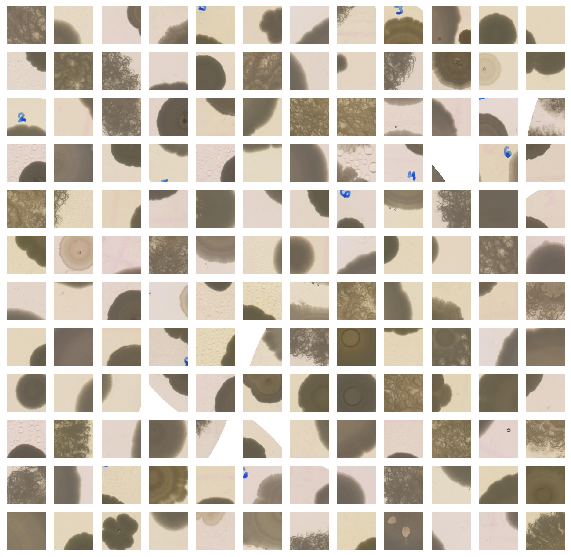

In [149]:
classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']
pos_patches = []
neg_patches = []

for type in ['Serial', 'Control', 'Streak']:
    for cls in classes:
        pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,type,cls)
        neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,type,cls)
        pos_class_patches = get_files(pos_folder)
        pos_patches = pos_patches + pos_class_patches
        neg_class_patches = get_files(neg_folder)
        neg_patches = neg_patches + neg_class_patches   

#We randomly visualize some generated patches.
fig, axes1 = plt.subplots(12,12,figsize=(10,10))
for j in range(12):
    for k in range(12):
        i = np.random.choice(range(len(pos_patches)))
        axes1[j][k].set_axis_off()
        patch = Image.open(pos_patches[i])
        axes1[j][k].imshow(np.asarray(patch), cmap="gray")

### If validation, let's downsample positive majority classes in validation type:

In [150]:
# type in ['Serial', 'Control', 'Streak']:

if validation_type in ['Serial', 'Control', 'Streak']:
    print('Before downsampling validation patches:')
    totals = {}
    classes = ['C1','C2-3','C4-7','C5','C6','C8','C9','C10']
    n_type, type_pos, type_neg = 0, 0, 0
    for cls in classes:
        pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,validation_type,cls)
        neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,validation_type,cls)
        n_pos = len(os.listdir(pos_folder))
        n_neg = len(os.listdir(neg_folder))
        total = n_pos + n_neg
        n_type += total
        type_pos += n_pos
        type_neg += n_neg
        print('total_{}: {} = {} positive + {} negative'.format(cls,total,n_pos,n_neg))
        totals['{}'.format(cls)] = n_pos if n_pos else 0
    print('Total {}: {} = {} positive + {} negative\n'.format(validation_type,n_type,type_pos,type_neg))
    
    minority = min(totals, key=totals.get)
    n_min = min(totals.values())
    for key, value in totals.items():
        if key != minority:
            n_to_delete = value - n_min
            root = '{}Positive/{}/{}_pos/'.format(patch_dir,validation_type,key)
            patches = os.listdir(root)
            patches_to_delete = np.random.choice(patches, n_to_delete, replace=False)
            for patch in patches_to_delete:
                os.remove(root + patch)

    print('After downsampling validation patches:')
    n_type, type_pos, type_neg = 0, 0, 0
    for cls in classes:
        pos_folder = '{}Positive/{}/{}_pos'.format(patch_dir,validation_type,cls)
        neg_folder = '{}Negative/{}/{}_neg'.format(patch_dir,validation_type,cls)
        n_pos = len(os.listdir(pos_folder))
        n_neg = len(os.listdir(neg_folder))
        total = n_pos + n_neg
        n_type += total
        type_pos += n_pos
        type_neg += n_neg
        print('total_{}: {} = {} positive + {} negative'.format(cls,total,n_pos,n_neg))
        totals['{}'.format(cls)] = n_pos if n_pos else 0
    print('Total {}: {} = {} positive + {} negative'.format(validation_type,n_type,type_pos,type_neg))

Before downsampling validation patches:
total_C1: 648 = 648 positive + 0 negative
total_C2-3: 1189 = 1189 positive + 0 negative
total_C4-7: 3139 = 3139 positive + 0 negative
total_C5: 1570 = 1570 positive + 0 negative
total_C6: 641 = 641 positive + 0 negative
total_C8: 857 = 857 positive + 0 negative
total_C9: 373 = 373 positive + 0 negative
total_C10: 3750 = 3750 positive + 0 negative
Total Control: 12167 = 12167 positive + 0 negative

After downsampling validation patches:
total_C1: 373 = 373 positive + 0 negative
total_C2-3: 373 = 373 positive + 0 negative
total_C4-7: 373 = 373 positive + 0 negative
total_C5: 373 = 373 positive + 0 negative
total_C6: 373 = 373 positive + 0 negative
total_C8: 373 = 373 positive + 0 negative
total_C9: 373 = 373 positive + 0 negative
total_C10: 373 = 373 positive + 0 negative
Total Control: 2984 = 2984 positive + 0 negative
